# TEXT2KG Using AMR as Intermediate representation - Clean
[ Insert brief intro to notebook ]
## Loading WikiText Dataset

The first step is loading a dataset containing the article. For our my use case, I will be loading the 'raw' version of WikiText (insertUrl)
by leveraging HuggingFace dataset loader.

In [1]:
from datasets import load_dataset

wikitext_raw = load_dataset("wikitext",'wikitext-2-raw-v1',split='train')
## Print an example line. Index = 1 because index = 0 has an empty string. 

print(wikitext_raw[1]) 

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 1085903.95 examples/s]

{'text': ' = Valkyria Chronicles III = \n'}


## Extracting the articles' first paragraph and titles
From the experimentation notebook and the information available on the WikiText Markup, we can define a logic that extracts the title and first section of each article from our dataset. 

In [2]:
# Import regular expressions to find Headings, delimited by equal signs: == Heding 2 == etc...
import re 

def extract_articles_info(wikitext, max_articles=None):
    """
    Input: WikiText dataser loaded via 'datasets', optional number of max articles to extract
    Returns: a list with titles, a list with paragraphs, count of articles extracted.
    """
    # Initialize variables for titles and contents
    titles = []
    contents = []
    article_counter = 0

    # Initialize variables for the current article
    content = ''
    # Flag to indicate whether currently processing article content
    in_article = False 

    # Iterate through the dataset
    for row in range(len(wikitext)):
        line = wikitext[row]["text"].strip()
    
        #if line.startswith('=') and we are OUTSIDE of the first section (here just shorthanded to 'article')
        if re.match(r'^= [^=].*?=$', line) and not in_article:
            # If the line starts with exactly one '= ', it's a title
            titles.append(wikitext[row]["text"].strip())
            content = ''
            in_article = True
            article_counter += 1
        elif line.startswith('= = '):
            # If the line starts with exactly two '==', it's the end of the section
            if in_article:
                contents.append(content.strip())
                in_article = False
        
                if max_articles and article_counter >= max_articles:
                    break
        elif in_article:
            # If in_article is True, it means we are still processing article content
            content += wikitext[row]["text"].strip()

    return titles, contents, article_counter 

In [3]:
# Extract the articles
titles, contents, count = extract_articles_info(wikitext_raw)

In [4]:
# To confirm we have extracted everything correctly:
print(titles[0],'\n')
print(contents[0],'\n')
# And check we have the same number of paragraphs as titles
if len(titles)==len(contents):
    print('True')

= Valkyria Chronicles III = 

Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " .The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

## Parsing and storing the content.

The plain text paragraphs are the starting point of the actual work. As seen in the experimentation, parsing on paragraph level is not as accurate as on the sentence level (this is not what AMR Parsers are trained for in general), hence we will have to feed sentences from out paragraphs to our parser. To achieve that, nltk tokenizer has been used. Parsing has been processed outside of the notebook and stored for ease of access in the follwing files:
1) paragraph_level_graphs.pk1
2) sentence_level_graphs.pk1
3) sentence_level_graphs_ids.pk1 (updated version of sentence_level_graphs_meta.pk1 that includes id field)

In the next step, a class Document is defined to store each of these as attributes of the class. This will help us building an object that will make it easier to operate on a per-document basis.
We load the files above, together with the plain text paragraphs and sentences:

In [5]:
import nltk 
import pickle
# Importing Vulcan modules to create an object. 
from vulcan.vulcan.pickle_builder.pickle_builder import PickleBuilder
from vulcan.vulcan.data_handling.format_names import FORMAT_NAME_NLTK_TREE, FORMAT_NAME_STRING, FORMAT_NAME_TOKEN, FORMAT_NAME_GRAPH_STRING
import subprocess
from io import StringIO

## Import the Document class

from classDocument import Document

# We would like to store, per article:
"""
1. Title
2. Paragraph
3. Paragraph level AMR ( As discussed, this is less accurate but we can store it anyway since we have it.)
4. (Sentence, Sentence AMR, Sentence AMR with metadata)
5. RDF Graphs per sentence. This will be generated with while processing the docs. 
"""
## Let us create a Class representing each Document

# Initializing the variables to genereate a Documents objects

titles     = titles   # This is from above 
paragraphs = contents # Also from above
sentences  = [nltk.sent_tokenize(paragraph) for paragraph in contents] # List comprehension to get sentences
# Load pickled data:
with open('paragraph_level_graphs.pk1', 'rb') as file:
    paras_amr = pickle.load(file)
with open('sentence_level_graphs.pk1', 'rb') as file:
    sents_amr = pickle.load(file)
with open('sentence_level_graphs_ids.pk1','rb') as file:
    sents_amr_meta = pickle.load(file)

With all the necessary data loaded, we can iterate over each article and build our document objects

In [6]:
all_documents = []

# Messy variable naming!! 
for title, paragraph, p_amr, sents, s_amrs, s_amr_meta in zip(titles, paragraphs, paras_amr, sentences, sents_amr, sents_amr_meta):
    sentences = list(zip(sents, s_amrs, s_amr_meta))
    doc = Document(title, paragraph, p_amr, sentences)
    all_documents.append(doc)
with open("all_documents.pickle", 'wb') as file:
    pickle.dump(all_documents, file)

In [7]:

doc0 = all_documents[0]
doc0.coreference_clusters
doc0.resolve_coreference()
print(doc0.coreference_clusters)
print(doc0.sentences[2][2])

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


{'rel-0': [(3, 'o3'), (3, 's'), (4, 'ii'), (7, 'ii'), (8, 'ii'), (9, 'ii')], 'rel-1': [(2, 'g'), (4, 'g')], 'rel-2': [(2, 'ii'), (4, 's2')]}
# ::id article1.sent3
# ::snt Released in January 2011 in Japan , it is the third game in the Valkyria series .
(g / game
      :ord (o / ordinal-entity
            :value 3)
      :part-of (g2 / game
            :name (n / name
                  :op1 "Valkyria"
                  :op2 "series"))
      :domain (ii / it)
      :ARG1-of (r / release-01
            :location (c / country
                  :name (n2 / name
                        :op1 "Japan"))
            :time (d / date-entity
                  :month 1
                  :year 2011)))


In [8]:
print(all_documents[0].sentences_rdf)

[]


In [9]:
# Print doc Title
print(all_documents[0].title)
# Print plain text sentence
print(all_documents[0].sentences[2][0])
# Print sentence's AMR with metadata (index 2, change to 1 for no metadata)
print(all_documents[0].sentences[2][2])

= Valkyria Chronicles III =
Released in January 2011 in Japan , it is the third game in the Valkyria series .
# ::id article1.sent3
# ::snt Released in January 2011 in Japan , it is the third game in the Valkyria series .
(g / game
      :ord (o / ordinal-entity
            :value 3)
      :part-of (g2 / game
            :name (n / name
                  :op1 "Valkyria"
                  :op2 "series"))
      :domain (ii / it)
      :ARG1-of (r / release-01
            :location (c / country
                  :name (n2 / name
                        :op1 "Japan"))
            :time (d / date-entity
                  :month 1
                  :year 2011)))


### Next, we store all such data in a format that ca be handled by Vulcan. 
This step can be ignored when rerunning the notebook. 

In [10]:
# Setting up the pickle object. 
pickler = PickleBuilder({"article title": FORMAT_NAME_STRING,
                             "paragraph": FORMAT_NAME_STRING,
                             "paragraph AMR": FORMAT_NAME_GRAPH_STRING,
                             "sentence": FORMAT_NAME_STRING,
                             "sentence AMR": FORMAT_NAME_GRAPH_STRING}
                            )

for doc in all_documents:
    for sent in doc.sentences:
        pickler.add_instances_by_name(
            {"article title": doc.title,
             "paragraph": doc.paragraph,
             "paragraph AMR": doc.paragraph_amr,
             "sentence": sent[0],
             "sentence AMR": sent[1]}
        )
pickler.write('processed_wikitext.pickle')

# AMR-LD

Using and adapted version of AMR-LD, we can convert AMR graphs into RDF files directly from a Notebook. For a more precise understanding of how this process is carried out, please refer to the classDocument.py file, which contains the methods that take care of the conversion. Here, it suffices to know that the script uses Standard Input and Standard output to activate the AMR-LD module, using as inputs the data stored in a Document object. The conversion can be operated on a single sentence in the document, however, this is prone to error as RDF-parsed sentences are appended to a list in the Object as illustrated below:


In [11]:
import pickle
from rdflib import Namespace
from classDocument import Document
# Load all_documents from the pickle file

with open("all_documents.pickle", 'rb') as file:
    all_documents = pickle.load(file)

# Assign a document to a variable
doc0 = all_documents[0]

# Convert Sentence of index 5 to rdf 
doc0.convert_amr_to_rdf(5)

# Access converted sentence 
print(doc0.sentences_rdf[0])


@prefix amr-core: <http://amr.isi.edu/rdf/core-amr#> .
@prefix amr-terms: <http://amr.isi.edu/rdf/amr-terms#> .
@prefix entity-types: <http://amr.isi.edu/entity-types#> .
@prefix propbank: <http://amr.isi.edu/frames/ld/v1.2.2/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

amr-core:Concept a rdfs:Class ;
    rdfs:label "AMR-Concept" .

amr-core:Role a rdfs:Class ;
    rdfs:label "AMR-Role" .

<http://amr.isi.edu/amr_data/article1.sent6#c2> a propbank:compose-01 ;
    propbank:compose-01.ARG0 <http://amr.isi.edu/amr_data/article1.sent6#p2> .

<http://amr.isi.edu/amr_data/article1.sent6#d> a propbank:design-01 ;
    propbank:design-01.ARG0 <http://amr.isi.edu/amr_data/article1.sent6#p> ;
    propbank:design-01.ARG1 <http://amr.isi.edu/amr_data/article1.sent6#c> .

<http://amr.isi.edu/amr_data/article1.sent6#h> a propbank:have-org-role-91 ;
    propbank:have-org-role-91.ARG0 <http://amr.isi.edu/amr_data/article1.sent6#p4> ;
    propbank:have-org-role-91.ARG1 <http://amr.isi.e

In [12]:
print(doc0.paragraph)

Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " .The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character designer Raita H

Hence, the converting sentence of Index 5 in a document will append sentence 5's RDF to the object's RDF list at index 0, which can easily result in erros. The recommended method is to apply document level conversion, as follows:


In [13]:
with open("all_documents.pickle", 'rb') as file:
    all_documents = pickle.load(file)
doc0 = all_documents[0]
# Convert all sentences to rdf 
doc0.all_sentences_to_rdf()
# Access the ordered list of RDF senteces
print(doc0.sentences_rdf[0])

@prefix amr-core: <http://amr.isi.edu/rdf/core-amr#> .
@prefix amr-terms: <http://amr.isi.edu/rdf/amr-terms#> .
@prefix entity-types: <http://amr.isi.edu/entity-types#> .
@prefix propbank: <http://amr.isi.edu/frames/ld/v1.2.2/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

amr-core:Concept a rdfs:Class ;
    rdfs:label "AMR-Concept" .

amr-core:Role a rdfs:Class ;
    rdfs:label "AMR-Role" .

<http://amr.isi.edu/amr_data/article1.sent1#l2> a propbank:light-04 ;
    propbank:light-04.ARG1 <http://amr.isi.edu/amr_data/article1.sent1#b2> .

<http://amr.isi.edu/amr_data/article1.sent1#root01> a amr-core:AMR ;
    amr-core:has-id "article1.sent1" ;
    amr-core:has-sentence "Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit ." ;
    amr-core:root <http://amr.isi.edu/amr_data/article1.sent1#t> .

propbank:light-04.ARG1 a propbank:FrameRole .

propbank:title-01.ARG1 a propbank:FrameRole .

propbank:title-01.ARG2 a propbank:FrameRole .

amr-terms:medium a 

It is also possible to visualize a sentence's RDF file in a graph. For this purpose, the library pyvis has been utilized, with a method dfined outside of the class 'Document' in the claddDocument.py module

In [14]:
# Import the method 
from classDocument import visualize_rdf_graph

## Assign the sentence's RDF to a variable
sentence_rdf = doc0.sentences_rdf[0]

# Visualize with the appropriate method, inputting the RDF file and a filename. 
# Access the visualization by opening the generated .html file in a web browser.
visualize_rdf_graph(sentence_rdf, "Sentence_visualization.html")


Sentence_visualization.html


With sentence-level RDF representation, we can generate a Document-level RDF representation by joining all the RDFs together. Before doing that, we want to identifies variables across sentences that represent the same entity. To this end, the AMR-coref module is used. 

In [15]:
# Resolve the coreference on the document
doc0.resolve_coreference()
# Print the coreferencing variable and clusters. 
doc0.print_coreference_clusters()

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Key: rel-0
  - Sentence id 3: operation | variable name:o3
  - Sentence id 3: story | variable name:s
  - Sentence id 4: it | variable name:ii
  - Sentence id 7: it | variable name:ii
  - Sentence id 8: it | variable name:ii
  - Sentence id 9: it | variable name:ii
Key: rel-1
  - Sentence id 2: game | variable name:g
  - Sentence id 4: game | variable name:g
Key: rel-2
  - Sentence id 2: it | variable name:ii
  - Sentence id 4: series | variable name:s2


Once the coreferences are resolved, we can proceed to create a Document-level graph that includes all the information about the coreferencing entities:

In [16]:
# Joing all the RDFs in a single graph, including the coreference clusters information
g = doc0.link_coreference_in_rdf()

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


# Querying 

## Q1

Similarly, we can check if and how we can query such file using SPARQL. I have handcrafted the query from the perspective of a user that wants to know where and when the videogame was released. Here's a breief explanation of how the query works:

- The query starts by selecting  game entities and retrieves their label.
- It then connects to the part of the game (because we know, from graph, that there are g and g2)
- Next, it moves to the release entity associated with the game.
- It retrieves the label of the location where the game was released.
- Finally, it retrieves the month and year of the release date directly from the time entity.

The query has to be handcrafted to reflect the structure of the RDF database and the relationships defined by the AMR meta-model. 

In [17]:
import pickle
from rdflib import Namespace
from classDocument import Document
# Load all_documents from the pickle file

with open("all_documents.pickle", 'rb') as file:
    all_documents = pickle.load(file)


In [18]:
from rdflib import Namespace

# Example SPARQL query
sparql_query = """
    # Select information about a game's release
    SELECT  ?Label
    WHERE {
        # Start with the game entity
        ?game a entity-types:game ;
            rdfs:label ?Label ;   # Retrieve the label of the series

    }
"""

# Execute the query
results = g.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('PlayStation Portable'),)
(rdflib.term.Literal('Valkyria of the Battlefield 3'),)
(rdflib.term.Literal('Valkyria Chronicles III'),)
(rdflib.term.Literal('Valkyria series'),)
(rdflib.term.Literal('Valkyria Chronicles II'),)
(rdflib.term.Literal('Valkyria Chronicles II'),)
(rdflib.term.Literal('Valkyria Azure Revolution'),)
(rdflib.term.Literal('PS4'),)


In [19]:
from rdflib import Namespace

# Example SPARQL query
sparql_query = """
    # Select information about a game's release
    SELECT ?seriesLabel ?location ?month ?year ?gamePartURI ?gameLabel
    WHERE {
        # Start with the game entity
        ?game a entity-types:game ;
            rdfs:label ?seriesLabel ;   # Retrieve the label of the series

            # Connect to the part of the game
            amr-terms:part ?gamePartURI .

        ## Insert Game label extraction here ##
        
        # Move to the release entity associated with the game
        ?release a propbank:release-01 ;
            propbank:release-01.ARG1 ?gamePartURI ;

            # Retrieve the label of the location where the game was released
            amr-terms:location/rdfs:label ?location ;

            # Retrieve the month and year of the release date directly from the time entity
            # remember the slash to traverse directly to a connected node!
            amr-terms:time/amr-terms:month ?month ;
            amr-terms:time/amr-terms:year ?year .
    }
"""

# Execute the query
results = g.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Valkyria series'), rdflib.term.Literal('Japan'), rdflib.term.Literal('1'), rdflib.term.Literal('2011'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent3#g'), None)


In [20]:
doc0.title

'= Valkyria Chronicles III ='

The crafted query aligns with the RDF database structure and adheres to the relationships defined by the AMR meta-model. The output from the query, although almost accurate, reveals an issue. When extracting the label from an entity that is part of a series, the query with label extraction yields nothing.

        ?gamePartURI a ?something;
            rdfs:label ?gameLabel . # Retrieve the label of the game

To address this problem, an alternative approach is suggested. By reversing the query and starting with the known label, information about the associated node is retrieved. 

In [21]:
sparql_query = """
SELECT ?game ?predicate ?object 
WHERE {
    # Search something of type game with a specific label
    ?game a entity-types:game ;
          rdfs:label 'Valkyria of the Battlefield 3' .  # Specify the desired label

    # Retrieve additional information about the node
    #?game ?predicate ?object.
    
}
"""
# Execute the query
results = g.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent2#g'), None, None)


The output from this reverse query provides a URI related to the specified label. However, this URI does not establish a direct or indirect connection to the resource identified as part of the video game series.

In [22]:
sparql_query = """
SELECT ?gameURI ?cluster
WHERE {
    # Search something of type game with a specific label
    ?gameURI a entity-types:game ;
          rdfs:label 'Valkyria of the Battlefield 3' .  # Specify the desired label

    # Retrieve additional information about the node
    ?gameURI coreference:sameAs ?cluster
}
"""
# Execute the query
results = g.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


### Q1 - Conclusion
With this manual query evaluation, one of the shortcomings of this approach becomes evident. The text indicates that "Valkyria of the Battlefield 3" is a part of the larger Valkyria Series Videogames. While this relationship is correctly represented in RDF triples, the use of pronouns and coreferencing introduces a loss of information. Specifically, the graph correctly indicates that "It" (referring to Valkyria of the Battlefield 3) is part of the broader video game series, but there is no direct or indirect connection to the specific video game's name from the pronoun node.

In summary, the current coreference resolver presents a limitation in capturing such relationships. A more robust coreference resolver is recommended to mitigate this shortcoming. For the given example query, this limitation translates to a challenge in directly answering questions such as "Which video games are part of the Valkyria Series?" due to the loss of connection between specific game names and their corresponding series.

In [23]:
from rdflib import Namespace

# Example SPARQL query
sparql_query = """
    # Select information about a game's release
    SELECT ?game ?Label 
    WHERE {
        # Start with the game entity
        ?game a entity-types:game ;
            rdfs:label ?Label ;   # Retrieve the label of the game
    }
"""

# Execute the query
results = g.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent2#g3'), rdflib.term.Literal('PlayStation Portable'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent2#g'), rdflib.term.Literal('Valkyria of the Battlefield 3'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent2#g2'), rdflib.term.Literal('Valkyria Chronicles III'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent3#g2'), rdflib.term.Literal('Valkyria series'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent4#g2'), rdflib.term.Literal('Valkyria Chronicles II'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent11#g'), rdflib.term.Literal('Valkyria Chronicles II'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent12#g'), rdflib.term.Literal('Valkyria Azure Revolution'))
(rdflib.term.URIRef('http://amr.isi.edu/amr_data/article1.sent12#g2'), rdflib.term.Literal('PS4'))


### Q2 

Going on, letus examine a second document. We can read the text below, and try to come up with interesting queries to test our Graph's IR abilities.

In [24]:
## Check text
doc2=all_documents[1]
print(doc2.title)
for sentence in doc2.sentences:
    print(sentence[0])

= Tower Building of the Little Rock Arsenal =
The Tower Building of the Little Rock Arsenal , also known as U.S. Arsenal Building , is a building located in MacArthur Park in downtown Little Rock , Arkansas .
Built in 1840 , it was part of Little Rock 's first military installation .
Since its decommissioning , The Tower Building has housed two museums .
It was home to the Arkansas Museum of Natural History and Antiquities from 1942 to 1997 and the MacArthur Museum of Arkansas Military History since 2001 .
It has also been the headquarters of the Little Rock Æsthetic Club since 1894 .The building receives its name from its distinct octagonal tower .
Besides being the last remaining structure of the original Little Rock Arsenal and one of the oldest buildings in central Arkansas , it was also the birthplace of General Douglas MacArthur , who became the supreme commander of US forces in the South Pacific during World War II .
It was also the starting place of the Camden Expedition .
In 2

In [25]:
# create linked graph
g2 = doc2.link_coreference_in_rdf()

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [26]:
# Query
sparql_query = """
    SELECT ?building ?location
    WHERE {
        ?buildingURI a entity-types:building;
            rdfs:label ?building ;
            amr-terms:location/ rdfs:label ?location .
    }
"""
# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Tower Building of the Little Rock Arsenal'), rdflib.term.Literal('MacArthur Park'))


Looking at the content of the first sentence, it seems as the graph is able to retrieve simple information in a within-sentence context, as shown by the query above which correctly returns the Building and its associated location, as described in the sentence. To take this a step further, we can try and expand the query to retrive the location of the location (tower locatad in park, park located in City in Arkansas)

In [27]:
sparql_query = """
    SELECT ?building ?location ?location2URI 

    WHERE {
        ?buildingURI a entity-types:building;
            rdfs:label ?building ;
            amr-terms:location ?locationURI.
        ?locationURI rdfs:label ?location.
        # UP UNTIL HERE, IT IS EQUIVALENT TO THE ABOVE.

        ?locationURI amr-terms:location ?location2URI.
    }
"""

# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)

    


(rdflib.term.Literal('Tower Building of the Little Rock Arsenal'), rdflib.term.Literal('MacArthur Park'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent1#d'))


From the above query, we can see the URI for the park's location: lets check that node in the turtle file (it is all the way at the bottom). We can se that the node is simply identified as a type of AMR term 'downtown'. We can also se that the variable of type City includes such node as part of the city. 

In [28]:
print(doc2.sentences_rdf[0])

@prefix amr-core: <http://amr.isi.edu/rdf/core-amr#> .
@prefix amr-terms: <http://amr.isi.edu/rdf/amr-terms#> .
@prefix entity-types: <http://amr.isi.edu/entity-types#> .
@prefix propbank: <http://amr.isi.edu/frames/ld/v1.2.2/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

amr-core:Concept a rdfs:Class ;
    rdfs:label "AMR-Concept" .

amr-core:Role a rdfs:Class ;
    rdfs:label "AMR-Role" .

<http://amr.isi.edu/amr_data/article2.sent1#c> a entity-types:city ;
    rdfs:label "Little Rock" ;
    amr-terms:location <http://amr.isi.edu/amr_data/article2.sent1#s> ;
    amr-terms:part <http://amr.isi.edu/amr_data/article2.sent1#d> .

<http://amr.isi.edu/amr_data/article2.sent1#k> a propbank:know-02 ;
    propbank:know-02.ARG1 <http://amr.isi.edu/amr_data/article2.sent1#b> ;
    propbank:know-02.ARG2 <http://amr.isi.edu/amr_data/article2.sent1#b2> ;
    amr-terms:mod <http://amr.isi.edu/amr_data/article2.sent1#a> .

<http://amr.isi.edu/amr_data/article2.sent1#root01> a amr-core:

The challenges in constructing effective queries demonstarte several issue within the graph structure. One significant difficulty is the presence of indirect relationships. For instance, we could expect a a straightforward connection from building to park, park to city, and city to state. However, this connection is hindered by the intermediate node 'downtown'. Instead of a direct 'location' edge, the link between the park and city is established through a 'part' edge, meaning that downtown is a part of the city. This introduces an additional layer of complexity in navigating the relationships.

In this contex, the concept of 'downtown' increases the level of detail represented in the graph. Moreover, let's suppose the text placed the building on the east side of the park: how would this increased granularity affect the comlpexity of the traversal process? 

In short, the challenges arise when traversing multiple complcepts and intermediary steps that are not consistently represented throughout the Knowledge Graph (KG). Efficient informaton retrivial requires knowing the graph's structure and a carful navigation to account for the intricacies and variation in the granuarity of the information. 

In [29]:
# Query
sparql_query = """
    SELECT ?building ?location ?location3 ?location4
    WHERE {
    
        ?buildingURI a entity-types:building;
            rdfs:label ?building ;
            amr-terms:location ?locationURI.
        # Extract first location label
        ?locationURI rdfs:label ?location.
        # Travers the downtown edge (to connect with city) without retrieving the label 
        ?locationURI amr-terms:location ?location2URI.
        # Find something connected to downtown  and get the label 
        ?location3URI ?predicate ?location2URI;
            rdfs:label ?location3 .
        # Check if that last resource has a location, if so extract the label (not really if statement)
        ?location3URI amr-terms:location/ rdfs:label ?location4

    }
"""
# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Tower Building of the Little Rock Arsenal'), rdflib.term.Literal('MacArthur Park'), rdflib.term.Literal('Little Rock'), rdflib.term.Literal('Arkansas'))


We have been able to retrive information within-sentence. Going on, lets verify if we can retrieve the museum that the building housed. We can start by having a look at rdf representation of the sentence containing the museum. 

In [30]:
print(doc2.sentences_rdf[3])
print(doc2.sentences[3][2])

@prefix amr-core: <http://amr.isi.edu/rdf/core-amr#> .
@prefix amr-terms: <http://amr.isi.edu/rdf/amr-terms#> .
@prefix entity-types: <http://amr.isi.edu/entity-types#> .
@prefix propbank: <http://amr.isi.edu/frames/ld/v1.2.2/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

amr-core:Concept a rdfs:Class ;
    rdfs:label "AMR-Concept" .

amr-core:Role a rdfs:Class ;
    rdfs:label "AMR-Role" .

<http://amr.isi.edu/amr_data/article2.sent4#root01> a amr-core:AMR ;
    amr-core:has-id "article2.sent4" ;
    amr-core:has-sentence "It was home to the Arkansas Museum of Natural History and Antiquities from 1942 to 1997 and the MacArthur Museum of Arkansas Military History since 2001 ." ;
    amr-core:root <http://amr.isi.edu/amr_data/article2.sent4#a> .

propbank:FrameRole a amr-core:Role ;
    rdfs:label "AMR-PropBank-Role" .

amr-terms:domain a amr-core:Role .

amr-terms:op1 a amr-core:Role .

amr-terms:op2 a amr-core:Role .

amr-terms:poss a amr-core:Role .

amr-terms:time a am

We can see that 'it' (our tower) 'houses' 2 option, each of which links to the possesions (the museums). However, a first downside to this structure is the scarce consistency in the entity type:
the two different instance of museums receive different types, as one is encoded as a facility (#f), while the other (#m) receives a musem type.

Additionally, our pronoun does not seem to carry any additional information. However the RDF File is only representing the sentence before the Document KG generation. We can again inspect the pronoun URI to identify connected coreferenced entities, and only select the ones that have labels:

In [31]:
# Query
sparql_query = """
    SELECT ?corefCluster ?relatedEntity ?entityLabel
    WHERE  {
    <http://amr.isi.edu/amr_data/article2.sent4#ii> coreference:sameAs ?corefCluster .
    ?relatedEntity coreference:sameAs  ?corefCluster;
         rdfs:label ?entityLabel .
}
"""

# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.URIRef('http://example.org/cluster/rel-1'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent5#o'), rdflib.term.Literal('Little Rock Ages Club'))


Based on this query, we can see that there is only node coreferencing the pronoun 'it' in the document that also has a label associated with it, namely "Little Rock Ages Club". As we know from the full text however, this is also incorrect, which means that the current structure does not represent the fact that the 'Tower building of Little Rock Arsenal" has ever housed any museum. Instead, it would be the Little Rock ages Club that has housed the museums. As a note, the entity is also misnamed compared witht he original text, probably an error arising in the AMR Parsing due to special charachter. 
Additionally, because of the complex graph structure of even such a simple sentence, I haven't been able to traverse the graph from the museum to the pronoun node, nor vice versa, despite the tentatives in the queries below. 



In [32]:
# Query
sparql_query = """
SELECT ?museumLabel ?museumType
WHERE {
  ?museumURI a ?museumType ;              # Selecting entities and their types
          rdfs:label ?museumLabel .

  FILTER ( ?museumType = entity-types:facility || ?museumType = entity-types:museum ) .  # Filtering for specific types
}
"""
# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Arkansas Museum of Natural History and _Antiquities'), rdflib.term.URIRef('http://amr.isi.edu/entity-types#museum'))
(rdflib.term.Literal('MacArthur Museum of Arkansas Military History'), rdflib.term.URIRef('http://amr.isi.edu/entity-types#facility'))
(rdflib.term.Literal('Little Rock Arsenal'), rdflib.term.URIRef('http://amr.isi.edu/entity-types#facility'))


In [33]:
# Query
sparql_query = """
SELECT ?museumLabel ?SecondLevelURI ?PURI 
WHERE {
  ?museumURI a ?museumType ;
          rdfs:label ?museumLabel .

  FILTER ( ?museumType = entity-types:facility || ?museumType = entity-types:museum ) .

  ?FirstLevelURI ?somePredicate ?museumURI .

  ?SecondLevelURI ?somePredicate2 ?FirstLevelURI .

  ?SecondLevelURI ?somePredicate3 ?PURI .
  FILTER (?somePredicate3 != ?somePredicate2)

}



"""
# Execute the query
results = g2.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/"),
    'coreference' : Namespace("http://example.org/cluster/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Arkansas Museum of Natural History and _Antiquities'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#a'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#ii'))
(rdflib.term.Literal('Arkansas Museum of Natural History and _Antiquities'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#a'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#h2'))
(rdflib.term.Literal('Arkansas Museum of Natural History and _Antiquities'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#a'), rdflib.term.URIRef('http://amr.isi.edu/rdf/core-amr#and'))
(rdflib.term.Literal('MacArthur Museum of Arkansas Military History'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#a'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#ii'))
(rdflib.term.Literal('MacArthur Museum of Arkansas Military History'), rdflib.term.URIRef('http://amr.isi.edu/amr_data/article2.sent4#a'), rdflib.term.URIRef('h

# Evaluation Metrics

The evaluation metrics include:
- precision,
- recall
- F1 

These are computed for the Named Entities contained in the text as recognized by Spacy's NER. This metric, although not extensive, can provide an easy, 'naive' scoring method for at least one of the task in which our pipline has to perform correctly.
 The idea is comparing the labels in our graph with the entities extracted by Spacy NLP as a gold standard. 
For this metrics, digits have been excluded from the gold standard, as our approach extracts dates differently than labels (amr-terms:date, :year, :day, etcetera). Refining this metrics to account for mispellings in the parsing ('s, special characters, etc.) using string similarity or others, could further improve the scores


In [34]:
# Compute metrics on the document 
doc0.compute_metrics()

/home/riccardo/anaconda3/envs/Project1/lib/python3.8/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


(0.5454545454545454, 0.5, 0.5217391304347826)

These metrics have been computed for the whole dataset and stored to a file in orderd to allow a more refined analysis. Here we load the file using Pandas, and check its descriptive stats

In [35]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("precision_recall_f1_data.csv"  )
# Display descriptive statistics for the original DataFrame

print("Descriptive Statistics - Original Data:")
print(df.describe())


Descriptive Statistics - Original Data:
        Precision      Recall          F1
count  611.000000  611.000000  611.000000
mean     0.529393    0.368738    0.426613
std      0.179521    0.154625    0.156234
min      0.000000    0.000000    0.000000
25%      0.437500    0.264706    0.325581
50%      0.540541    0.366667    0.434783
75%      0.652174    0.476190    0.533333
max      1.000000    0.928571    0.880000


Next, we can do some basic filtering to remove some outliers. We will use Inter Quartile range and drop out the Top and bottom quartile 

In [36]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate the IQR for each metric
IQR = Q3 - Q1

# Create a boolean mask to identify outliers
outliers_mask = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

# Create a new DataFrame without outliers
df_no_outliers = df[outliers_mask]

# Calculate average metrics for both datasets
avg_values_original = df.mean()
avg_values_no_outliers = df_no_outliers.mean()

# Display the DataFrames and average values
print("Original DataFrame:")
print(df)

print("\nDataFrame without Outliers (IQR):")
print(df_no_outliers)

print("\nAverage Values (Original):")
print(avg_values_original)

print("\nAverage Values (No Outliers):")
print(avg_values_no_outliers)


Original DataFrame:
     Precision    Recall        F1
0     0.545455  0.500000  0.521739
1     0.600000  0.450000  0.514286
2     0.562500  0.428571  0.486486
3     0.800000  0.444444  0.571429
4     0.200000  0.111111  0.142857
..         ...       ...       ...
606   0.500000  0.636364  0.560000
607   0.652174  0.428571  0.517241
608   0.666667  0.571429  0.615385
609   0.538462  0.466667  0.500000
610   0.583333  0.388889  0.466667

[611 rows x 3 columns]

DataFrame without Outliers (IQR):
     Precision    Recall        F1
0     0.545455  0.500000  0.521739
1     0.600000  0.450000  0.514286
2     0.562500  0.428571  0.486486
3     0.800000  0.444444  0.571429
4     0.200000  0.111111  0.142857
..         ...       ...       ...
606   0.500000  0.636364  0.560000
607   0.652174  0.428571  0.517241
608   0.666667  0.571429  0.615385
609   0.538462  0.466667  0.500000
610   0.583333  0.388889  0.466667

[587 rows x 3 columns]

Average Values (Original):
Precision    0.529393
Recall 

Which leads to the follwin improvements in our metrics

In [37]:
# Calculate improvement percentage for each metric
improvement_percentage_precision = ((avg_values_no_outliers["Precision"] - avg_values_original["Precision"]) / avg_values_original["Precision"]) * 100
improvement_percentage_recall = ((avg_values_no_outliers["Recall"] - avg_values_original["Recall"]) / avg_values_original["Recall"]) * 100
improvement_percentage_f1 = ((avg_values_no_outliers["F1"] - avg_values_original["F1"]) / avg_values_original["F1"]) * 100

# Display improvement percentages
print("Improvement Percentage for Precision: {:.2f}%".format(improvement_percentage_precision))
print("Improvement Percentage for Recall: {:.2f}%".format(improvement_percentage_recall))
print("Improvement Percentage for F1: {:.2f}%".format(improvement_percentage_f1))


Improvement Percentage for Precision: 2.17%
Improvement Percentage for Recall: 1.85%
Improvement Percentage for F1: 2.11%


And we can check the descriptive again

In [38]:
# Display descriptive statistics for the DataFrame without outliers
print("\nDescriptive Statistics - No Outliers:")
print(df_no_outliers.describe())
print("Descriptive Statistics - Original Data:")
print(df.describe())


Descriptive Statistics - No Outliers:
        Precision      Recall          F1
count  587.000000  587.000000  587.000000
mean     0.540886    0.375556    0.435604
std      0.154835    0.138124    0.137605
min      0.142857    0.083333    0.105263
25%      0.444444    0.270270    0.333333
50%      0.545455    0.368421    0.439024
75%      0.652174    0.476190    0.533333
max      0.916667    0.769231    0.800000
Descriptive Statistics - Original Data:
        Precision      Recall          F1
count  611.000000  611.000000  611.000000
mean     0.529393    0.368738    0.426613
std      0.179521    0.154625    0.156234
min      0.000000    0.000000    0.000000
25%      0.437500    0.264706    0.325581
50%      0.540541    0.366667    0.434783
75%      0.652174    0.476190    0.533333
max      1.000000    0.928571    0.880000


Lets plot the outliers

In [39]:

# Plot boxplots for each metric before and after filtering outliers
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Boxplots for Precision, Recall and F1')

# Boxplot for Precision
df.boxplot(column='Precision', ax=axs[0], showfliers=True)
axs[0].set_title('Precision')

# Boxplot for Recall
df.boxplot(column='Recall', ax=axs[1], showfliers=True)
axs[1].set_title('Recall')

# Boxplot for F1
df.boxplot(column='F1', ax=axs[2], showfliers=True)
axs[2].set_title('F1')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: name 'plt' is not defined

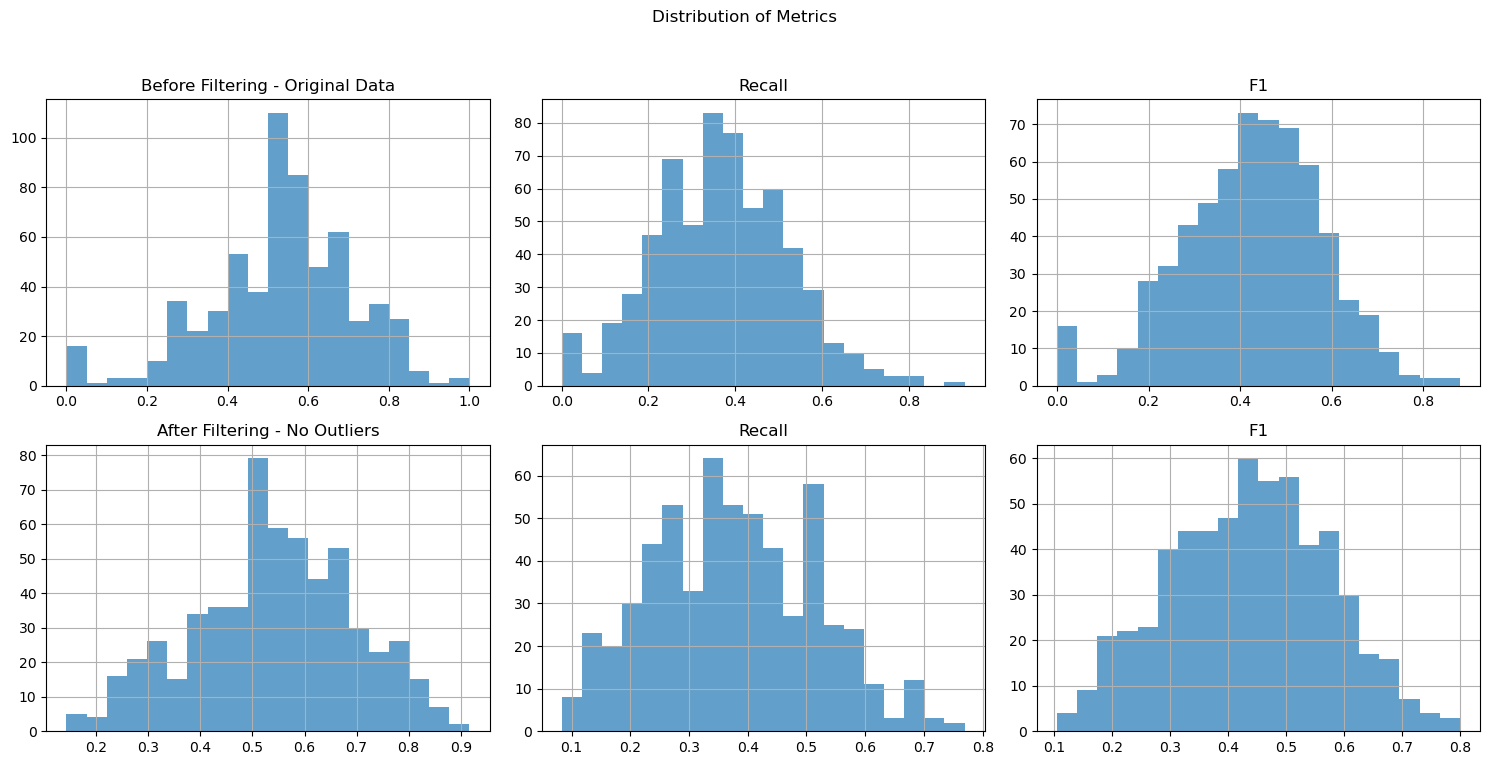

In [ ]:
import matplotlib.pyplot as plt
# Plot histograms for each column before and after filtering outliers
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribution of Metrics')

df.hist(bins=20, alpha=0.7, ax=axs[0])
axs[0, 0].set_title('Before Filtering - Original Data')

df_no_outliers.hist(bins=20, alpha=0.7, ax=axs[1])
axs[1, 0].set_title('After Filtering - No Outliers')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

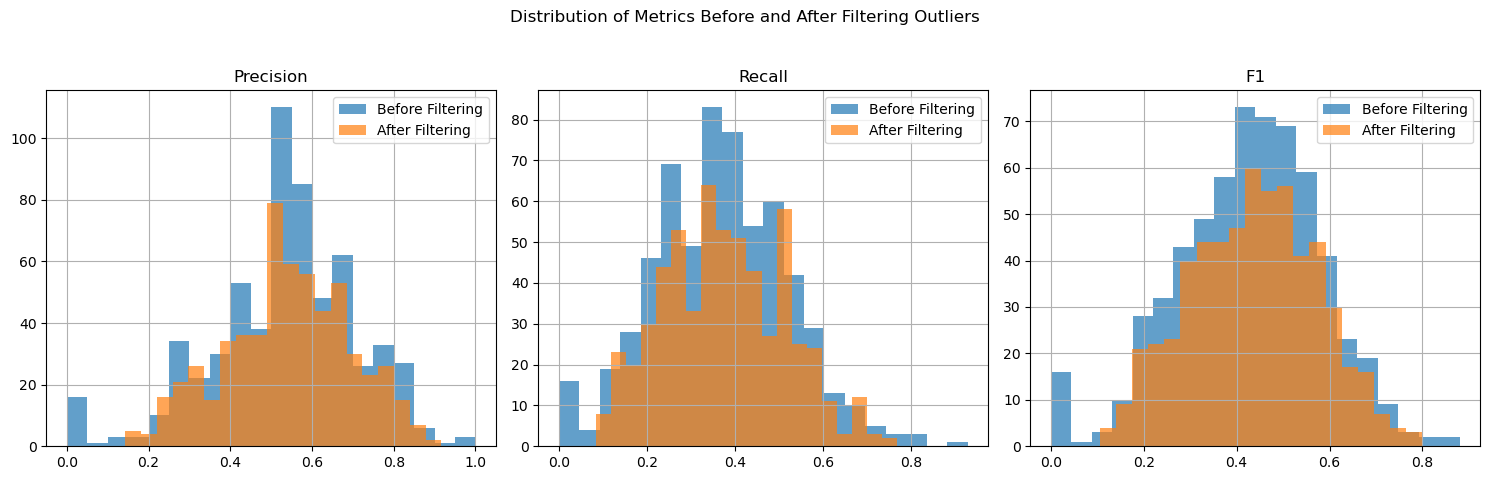

In [ ]:

# Plot histograms for each metric before and after filtering outliers
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution of Metrics Before and After Filtering Outliers')

# Plot Precision
df['Precision'].hist(bins=20, alpha=0.7, label='Before Filtering', ax=axs[0])
df_no_outliers['Precision'].hist(bins=20, alpha=0.7, label='After Filtering', ax=axs[0])
axs[0].set_title('Precision')
axs[0].legend()

# Plot Recall
df['Recall'].hist(bins=20, alpha=0.7, label='Before Filtering', ax=axs[1])
df_no_outliers['Recall'].hist(bins=20, alpha=0.7, label='After Filtering', ax=axs[1])
axs[1].set_title('Recall')
axs[1].legend()

# Plot F1
df['F1'].hist(bins=20, alpha=0.7, label='Before Filtering', ax=axs[2])
df_no_outliers['F1'].hist(bins=20, alpha=0.7, label='After Filtering', ax=axs[2])
axs[2].set_title('F1')
axs[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
